# Terrain Classification Pipeline
Created by Keenan McConkey 2019.08.01, edited by Mahsa Khalili 2021.01.11

- **Import notebook dependencies**
- **Defining notebook variables**
- **Defining notebook parameters **
- **Importing datasets**
    - Time features, frequency features, FFT-features, PSD-features 
    - Add a new relabeled column: {no-motion, indoor, asphalt, sidewalk, grass, gravel}
- **Feature correlation analysis**
- **Creating the classification pipeline**
    - data normalization
    - features selection
    - classification
    - gridsearch to optimize hyperparameters
    - export model
- **Model evaluation**
    - examine model accuray, confusion matrix
- **Summary of the gridsearch results**
    - best model parameters
    - best selected features

### Import dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import time
import csv

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import plot_confusion_matrix

# preprocessing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
# from yellowbrick.model_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# cross-validation
from sklearn.model_selection import KFold

# pipeline 
from sklearn.pipeline import Pipeline

# grid search
from sklearn.model_selection import GridSearchCV
## explicitly require this experimental feature
# from sklearn.experimental import enable_halving_search_cv 
# from sklearn.model_selection import HalvingGridSearchCV

# ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import PredefinedHoldoutSplit # check whether this is used

# import/export
import joblib
from joblib import dump, load

### Notebook Variables

In [2]:
# Importing which user's data ['All', 'Jaimie', 'Keenan', 'Kevin', 'Mahsa']
USER = 'All' 

# Which measurements to import ['Manual', 'Power', 'Remote']
POWER_TYPE = 'Power' 

# number of datapoints in each segment 
## good practice for fft analysis: better to have a value that's a power of 2
SAMP_SLICE = 1024 

# target label
## possible choices: ['Label', 'Relabeled', 'Relabeled2', 'Label_IO']
LABELS = 'Label_IO' 

# Features to be used for classification
## possible choices: ['TimeFeats', 'FreqFeats', 'FFTs', 'PSDs', 'TimeFreqFeats', 'FFTPSDFeats', 'AllFeats']
CLASS_FEATS = 'FreqFeats'

### Notebook Parameters (Constant values)

In [3]:
# original labeled data
Label = ['No_motion', 'Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']

# relabel data to reflect important classification goals
Relabeled = ['No_motion', 'Indoor', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']

# relabel data to reflect important classification goals
Relabeled2 = ['No_motion', 'Indoor', 'Asphalt-Sidewalk', 'Grass', 'Gravel']

# labeles for indoor/outdooor classification
Label_IO = ['No_motion', 'Indoor' , 'Outdoor']

# list of possible classification targets
target_label_list = ['Label', 'Label_IO', 'Relabeled', 'Relabeled2']

# dictionary of target label names & associated list of labels
target_label_dic = {'Label':Label, 'Label_IO':Label_IO , 'Relabeled': Relabeled, 'Relabeled2': Relabeled2}

# feature extracted datasets
features = ['TimeFeats', 'FreqFeats', 'FFTs', 'PSDs']

# original measurements
axes = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']

## Part 1 - Importing Datasets
### 1.1. Functions for Data Import

In [4]:
'''Get the integer terrain value of a given label'''
def get_label_num(list_, label_):
    for i, label in enumerate(list_):
        if label in label_:
            return (i)
    
'''Get the name associated with a terrain integer'''
def get_label_name(list_, label_num):
    return list_[label_num]

In [5]:
def combine_datasets(datasets):
    
    dataset_list = []
    
    for dataset in datasets:
        df_labels = dataset[['Label', 'Label_IO']]
        dataset_list.append(dataset.drop(columns = ['Label', 'Label_IO']))
        
    df_concat = pd.concat(dataset_list, axis = 1)
    df_combined = pd.concat([df_labels, df_concat], axis = 1)
                              
    return df_combined

### 1.2. TRAIN DATASETS: Import Processed Data from Each User

In [6]:
# get path to train datasets
CURR_PATH = os.path.abspath('.')
DATA_PATH = os.path.join(CURR_PATH, 'processed_data', 'Train-TwoThird-balanced')

datasets_dic = {}

# create a dictionary of all featured datasets
for feature in features:
    
    filename = os.path.join(DATA_PATH, feature + '.csv')
                
    # Read data and update current user dictionary
    df = pd.read_csv(filename)
    datasets_dic.update({feature: df})
    
datasets_dic.update({'AllFeats':combine_datasets(list(datasets_dic.values()))})
datasets_dic.update({'TimeFreqFeats':combine_datasets([datasets_dic['TimeFeats'],datasets_dic['FreqFeats']])})
datasets_dic.update({'FFTPSDFeats':combine_datasets([datasets_dic['FFTs'],datasets_dic['PSDs']])})

In [7]:
# Check some data
for label, dataset in datasets_dic.items():
    print(label, dataset.shape)
    display(dataset.head())
    print('\n')

TimeFeats (3590, 44)


,Label_IO,Label,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,ZCR X Accel,Mean Y Accel,...,Min Y Gyro,RMS Y Gyro,ZCR Y Gyro,Mean Z Gyro,Std Z Gyro,Norm Z Gyro,Max Z Gyro,Min Z Gyro,RMS Z Gyro,ZCR Z Gyro
0,2,4,0.417644,0.907934,31.980314,2.675340,-1.468453,0.999385,0.043945,-1.091654,...,-0.249929,0.058888,0.068359,-0.733297,0.399710,26.725128,0.232603,-1.489061,0.835160,0.000977
1,2,4,0.237338,0.846960,28.146724,3.086861,-1.468453,0.879585,0.048828,-1.465217,...,-0.249929,0.065540,0.084961,-0.999656,0.262005,33.069451,-0.418996,-1.508020,1.033420,0.000000
2,2,4,0.159782,1.068649,34.576901,3.907027,-2.499257,1.080528,0.055664,-1.837595,...,-0.230291,0.077113,0.085938,-1.094755,0.199305,35.607974,-0.623763,-1.508020,1.112749,0.000000
3,2,4,0.073723,0.979585,31.435375,3.907027,-2.499257,0.982355,0.056641,-1.770049,...,-0.230291,0.076914,0.067383,-1.055028,0.199950,34.361868,-0.620970,-1.468878,1.073808,0.000000
4,2,4,0.151664,0.692464,22.684106,2.437135,-1.696359,0.708878,0.044922,-1.466527,...,-0.172885,0.052003,0.079102,-1.041075,0.255307,34.301544,-0.394088,-1.566423,1.071923,0.000000




FreqFeats (3590, 20)


,Label_IO,Label,RMSF X Accel,FC X Accel,RVF X Accel,RMSF Y Accel,FC Y Accel,RVF Y Accel,RMSF Z Accel,FC Z Accel,RVF Z Accel,RMSF X Gyro,FC X Gyro,RVF X Gyro,RMSF Y Gyro,FC Y Gyro,RVF Y Gyro,RMSF Z Gyro,FC Z Gyro,RVF Z Gyro
0,2,4,8.169346,5.982349,8.169346,9.374658,6.788802,9.374658,18.986362,17.572778,18.986362,8.136149,5.670393,8.136149,11.518041,7.654666,11.518041,2.016492,1.638998,2.016492
1,2,4,8.897161,6.744817,8.897161,10.375326,7.563495,10.375326,19.475963,18.168916,19.475963,8.576173,5.998561,8.576173,12.271749,8.432910,12.271749,1.988557,1.437631,1.988557
2,2,4,7.716003,5.578372,7.716003,11.635237,8.889539,11.635237,17.722684,15.979487,17.722684,9.121694,6.394247,9.121694,10.071622,7.083412,10.071622,2.332620,1.653368,2.332620
3,2,4,7.666648,5.654688,7.666648,11.564737,8.909552,11.564737,17.028623,15.263118,17.028623,8.686849,5.813304,8.686849,9.162814,6.277056,9.162814,2.184795,1.686969,2.184795
4,2,4,7.899769,6.067953,7.899769,8.878924,6.388325,8.878924,16.432541,14.501326,16.432541,9.902666,7.301384,9.902666,9.954443,6.486281,9.954443,2.062345,1.525570,2.062345




FFTs (3590, 620)


,Label_IO,Label,FFT 0.0 Hz X Accel,FFT 0.3 Hz X Accel,FFT 0.6 Hz X Accel,FFT 0.9 Hz X Accel,FFT 1.2 Hz X Accel,FFT 1.5 Hz X Accel,FFT 1.8 Hz X Accel,FFT 2.1 Hz X Accel,...,FFT 27.2 Hz Z Gyro,FFT 27.5 Hz Z Gyro,FFT 27.8 Hz Z Gyro,FFT 28.1 Hz Z Gyro,FFT 28.4 Hz Z Gyro,FFT 28.7 Hz Z Gyro,FFT 29.0 Hz Z Gyro,FFT 29.3 Hz Z Gyro,FFT 29.6 Hz Z Gyro,FFT 29.9 Hz Z Gyro
0,2,4,0.344051,0.223742,0.235217,0.182794,0.130956,0.115759,0.027943,0.051224,...,0.000516,0.000511,0.000373,0.000475,0.000134,0.000192,0.000145,0.000210,0.000245,0.000394
1,2,4,0.041491,0.119634,0.184913,0.146318,0.132935,0.112952,0.159201,0.157194,...,0.000664,0.000432,0.000348,0.000222,0.000438,0.000211,0.000134,0.000297,0.000289,0.000122
2,2,4,0.008358,0.119132,0.079664,0.135219,0.294496,0.277996,0.137479,0.150969,...,0.000215,0.000415,0.000613,0.000698,0.000625,0.000296,0.000139,0.000145,0.000215,0.000184
3,2,4,0.237447,0.249536,0.330991,0.355074,0.194881,0.159417,0.044662,0.067447,...,0.000063,0.000057,0.000133,0.000198,0.000222,0.000272,0.000137,0.000091,0.000276,0.000234
4,2,4,0.285734,0.264851,0.135509,0.116627,0.167973,0.174560,0.121204,0.089833,...,0.000271,0.000308,0.000341,0.000224,0.000202,0.000350,0.000356,0.000226,0.000098,0.000264




PSDs (3590, 158)


,Label_IO,Label,PSD 0.0 Hz X Accel,PSD 1.2 Hz X Accel,PSD 2.3 Hz X Accel,PSD 3.5 Hz X Accel,PSD 4.7 Hz X Accel,PSD 5.9 Hz X Accel,PSD 7.0 Hz X Accel,PSD 8.2 Hz X Accel,...,PSD 18.8 Hz Z Gyro,PSD 19.9 Hz Z Gyro,PSD 21.1 Hz Z Gyro,PSD 22.3 Hz Z Gyro,PSD 23.4 Hz Z Gyro,PSD 24.6 Hz Z Gyro,PSD 25.8 Hz Z Gyro,PSD 27.0 Hz Z Gyro,PSD 28.1 Hz Z Gyro,PSD 29.3 Hz Z Gyro
0,2,4,0.004406,0.060457,0.047671,0.082074,0.043123,0.014272,0.017673,0.009024,...,0.000002,0.000001,0.000001,0.000001,7.866066e-07,7.604411e-07,1.111254e-06,8.010126e-07,5.728472e-07,3.194335e-07
1,2,4,0.008653,0.057620,0.047064,0.057600,0.072250,0.045797,0.018515,0.012365,...,0.000002,0.000004,0.000006,0.000003,4.160449e-06,3.442693e-06,1.803455e-06,1.273986e-06,7.361359e-07,2.304221e-07
2,2,4,0.007883,0.177023,0.166903,0.146870,0.145606,0.093738,0.025432,0.034016,...,0.000004,0.000007,0.000008,0.000004,4.739048e-06,3.934000e-06,1.401843e-06,7.233224e-07,6.763778e-07,2.080023e-07
3,2,4,0.005476,0.132137,0.071733,0.098103,0.122972,0.075374,0.023034,0.028804,...,0.000004,0.000002,0.000002,0.000002,1.387469e-06,1.225792e-06,8.413449e-07,3.806155e-07,1.379577e-07,1.297586e-07
4,2,4,0.002992,0.058436,0.029135,0.047209,0.085017,0.046989,0.007416,0.016973,...,0.000004,0.000001,0.000001,0.000002,7.185189e-07,1.098538e-06,1.414594e-06,5.469308e-07,3.704392e-07,2.918086e-07




AllFeats (3590, 836)


,Label,Label_IO,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,ZCR X Accel,Mean Y Accel,...,PSD 18.8 Hz Z Gyro,PSD 19.9 Hz Z Gyro,PSD 21.1 Hz Z Gyro,PSD 22.3 Hz Z Gyro,PSD 23.4 Hz Z Gyro,PSD 24.6 Hz Z Gyro,PSD 25.8 Hz Z Gyro,PSD 27.0 Hz Z Gyro,PSD 28.1 Hz Z Gyro,PSD 29.3 Hz Z Gyro
0,4,2,0.417644,0.907934,31.980314,2.675340,-1.468453,0.999385,0.043945,-1.091654,...,0.000002,0.000001,0.000001,0.000001,7.866066e-07,7.604411e-07,1.111254e-06,8.010126e-07,5.728472e-07,3.194335e-07
1,4,2,0.237338,0.846960,28.146724,3.086861,-1.468453,0.879585,0.048828,-1.465217,...,0.000002,0.000004,0.000006,0.000003,4.160449e-06,3.442693e-06,1.803455e-06,1.273986e-06,7.361359e-07,2.304221e-07
2,4,2,0.159782,1.068649,34.576901,3.907027,-2.499257,1.080528,0.055664,-1.837595,...,0.000004,0.000007,0.000008,0.000004,4.739048e-06,3.934000e-06,1.401843e-06,7.233224e-07,6.763778e-07,2.080023e-07
3,4,2,0.073723,0.979585,31.435375,3.907027,-2.499257,0.982355,0.056641,-1.770049,...,0.000004,0.000002,0.000002,0.000002,1.387469e-06,1.225792e-06,8.413449e-07,3.806155e-07,1.379577e-07,1.297586e-07
4,4,2,0.151664,0.692464,22.684106,2.437135,-1.696359,0.708878,0.044922,-1.466527,...,0.000004,0.000001,0.000001,0.000002,7.185189e-07,1.098538e-06,1.414594e-06,5.469308e-07,3.704392e-07,2.918086e-07




TimeFreqFeats (3590, 62)


,Label,Label_IO,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,ZCR X Accel,Mean Y Accel,...,RVF Z Accel,RMSF X Gyro,FC X Gyro,RVF X Gyro,RMSF Y Gyro,FC Y Gyro,RVF Y Gyro,RMSF Z Gyro,FC Z Gyro,RVF Z Gyro
0,4,2,0.417644,0.907934,31.980314,2.675340,-1.468453,0.999385,0.043945,-1.091654,...,18.986362,8.136149,5.670393,8.136149,11.518041,7.654666,11.518041,2.016492,1.638998,2.016492
1,4,2,0.237338,0.846960,28.146724,3.086861,-1.468453,0.879585,0.048828,-1.465217,...,19.475963,8.576173,5.998561,8.576173,12.271749,8.432910,12.271749,1.988557,1.437631,1.988557
2,4,2,0.159782,1.068649,34.576901,3.907027,-2.499257,1.080528,0.055664,-1.837595,...,17.722684,9.121694,6.394247,9.121694,10.071622,7.083412,10.071622,2.332620,1.653368,2.332620
3,4,2,0.073723,0.979585,31.435375,3.907027,-2.499257,0.982355,0.056641,-1.770049,...,17.028623,8.686849,5.813304,8.686849,9.162814,6.277056,9.162814,2.184795,1.686969,2.184795
4,4,2,0.151664,0.692464,22.684106,2.437135,-1.696359,0.708878,0.044922,-1.466527,...,16.432541,9.902666,7.301384,9.902666,9.954443,6.486281,9.954443,2.062345,1.525570,2.062345




FFTPSDFeats (3590, 776)


,Label,Label_IO,FFT 0.0 Hz X Accel,FFT 0.3 Hz X Accel,FFT 0.6 Hz X Accel,FFT 0.9 Hz X Accel,FFT 1.2 Hz X Accel,FFT 1.5 Hz X Accel,FFT 1.8 Hz X Accel,FFT 2.1 Hz X Accel,...,PSD 18.8 Hz Z Gyro,PSD 19.9 Hz Z Gyro,PSD 21.1 Hz Z Gyro,PSD 22.3 Hz Z Gyro,PSD 23.4 Hz Z Gyro,PSD 24.6 Hz Z Gyro,PSD 25.8 Hz Z Gyro,PSD 27.0 Hz Z Gyro,PSD 28.1 Hz Z Gyro,PSD 29.3 Hz Z Gyro
0,4,2,0.344051,0.223742,0.235217,0.182794,0.130956,0.115759,0.027943,0.051224,...,0.000002,0.000001,0.000001,0.000001,7.866066e-07,7.604411e-07,1.111254e-06,8.010126e-07,5.728472e-07,3.194335e-07
1,4,2,0.041491,0.119634,0.184913,0.146318,0.132935,0.112952,0.159201,0.157194,...,0.000002,0.000004,0.000006,0.000003,4.160449e-06,3.442693e-06,1.803455e-06,1.273986e-06,7.361359e-07,2.304221e-07
2,4,2,0.008358,0.119132,0.079664,0.135219,0.294496,0.277996,0.137479,0.150969,...,0.000004,0.000007,0.000008,0.000004,4.739048e-06,3.934000e-06,1.401843e-06,7.233224e-07,6.763778e-07,2.080023e-07
3,4,2,0.237447,0.249536,0.330991,0.355074,0.194881,0.159417,0.044662,0.067447,...,0.000004,0.000002,0.000002,0.000002,1.387469e-06,1.225792e-06,8.413449e-07,3.806155e-07,1.379577e-07,1.297586e-07
4,4,2,0.285734,0.264851,0.135509,0.116627,0.167973,0.174560,0.121204,0.089833,...,0.000004,0.000001,0.000001,0.000002,7.185189e-07,1.098538e-06,1.414594e-06,5.469308e-07,3.704392e-07,2.918086e-07


### 1.3. TEST DATASETS: Import Processed Data from Each User

In [8]:
# get path to train datasets
CURR_PATH = os.path.abspath('.')
DATA_PATH = os.path.join(CURR_PATH, 'processed_data', 'Test-OneThird-balanced')

test_datasets_dic = {}

# create a dictionary of all featured datasets
for feature in features:
    
    filename = os.path.join(DATA_PATH, feature + '.csv')
                
    # Read data and update current user dictionary
    df = pd.read_csv(filename)
    test_datasets_dic.update({feature: df})
    
test_datasets_dic.update({'AllFeats':combine_datasets(list(test_datasets_dic.values()))})
test_datasets_dic.update({'TimeFreqFeats':combine_datasets([test_datasets_dic['TimeFeats'],test_datasets_dic['FreqFeats']])})
test_datasets_dic.update({'FFTPSDFeats':combine_datasets([test_datasets_dic['FFTs'],test_datasets_dic['PSDs']])})

In [9]:
# Check some data
for label, dataset in test_datasets_dic.items():
    print(label, dataset.shape)
    display(dataset.head())
    print('\n')

TimeFeats (1607, 44)


,Label_IO,Label,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,ZCR X Accel,Mean Y Accel,...,Min Y Gyro,RMS Y Gyro,ZCR Y Gyro,Mean Z Gyro,Std Z Gyro,Norm Z Gyro,Max Z Gyro,Min Z Gyro,RMS Z Gyro,ZCR Z Gyro
0,2,4,0.490972,0.950083,34.222229,5.280722,-2.013216,1.069445,0.024414,1.024263,...,-0.215704,0.052778,0.087891,0.698806,0.401475,25.789537,1.489304,-0.278037,0.805923,0.001953
1,2,4,0.429220,0.998314,34.773568,5.280722,-2.030122,1.086674,0.031250,1.086302,...,-0.215704,0.050761,0.093750,0.742145,0.436537,27.552428,1.626520,-0.278037,0.861013,0.001953
2,2,4,0.028369,0.962901,30.826215,2.670142,-2.675289,0.963319,0.052734,1.196277,...,-0.269596,0.074675,0.091797,0.941653,0.296544,31.591772,1.626520,0.302023,0.987243,0.000000
3,2,4,-0.166364,0.929699,30.222942,2.438926,-2.675289,0.944467,0.068359,1.565490,...,-0.269596,0.084458,0.082031,1.041890,0.272848,34.464776,1.624010,0.526471,1.077024,0.000000
4,2,4,0.017092,0.930912,29.794211,2.541473,-2.524794,0.931069,0.064453,1.688857,...,-0.184262,0.068389,0.071289,1.027757,0.252753,33.868174,1.497907,0.585388,1.058380,0.000000




FreqFeats (1607, 20)


,Label_IO,Label,RMSF X Accel,FC X Accel,RVF X Accel,RMSF Y Accel,FC Y Accel,RVF Y Accel,RMSF Z Accel,FC Z Accel,RVF Z Accel,RMSF X Gyro,FC X Gyro,RVF X Gyro,RMSF Y Gyro,FC Y Gyro,RVF Y Gyro,RMSF Z Gyro,FC Z Gyro,RVF Z Gyro
0,2,4,8.048273,6.149016,8.048273,9.444501,6.638204,9.444501,17.714204,16.280908,17.714204,9.680661,7.287022,9.680661,15.319790,12.427664,15.319790,1.887356,1.526287,1.887356
1,2,4,7.984941,5.885248,7.984941,8.982319,6.065355,8.982319,16.100315,14.006347,16.100315,11.055525,8.392184,11.055525,14.845270,11.642735,14.845270,1.801210,1.451662,1.801210
2,2,4,9.800583,6.943039,9.800583,10.432468,7.134250,10.432468,17.689127,15.952424,17.689127,12.013069,9.381817,12.013069,15.780374,12.942894,15.780374,1.802646,1.332285,1.802646
3,2,4,10.715512,8.262469,10.715512,10.960555,7.634193,10.960555,18.318273,16.903061,18.318273,11.283124,8.721337,11.283124,16.191953,13.551576,16.191953,1.807651,1.272617,1.807651
4,2,4,9.982904,7.704395,9.982904,9.835037,6.667630,9.835037,17.748408,15.966089,17.748408,9.545448,6.990053,9.545448,15.217434,11.926853,15.217434,1.756785,1.273357,1.756785




FFTs (1607, 620)


,Label_IO,Label,FFT 0.0 Hz X Accel,FFT 0.3 Hz X Accel,FFT 0.6 Hz X Accel,FFT 0.9 Hz X Accel,FFT 1.2 Hz X Accel,FFT 1.5 Hz X Accel,FFT 1.8 Hz X Accel,FFT 2.1 Hz X Accel,...,FFT 27.2 Hz Z Gyro,FFT 27.5 Hz Z Gyro,FFT 27.8 Hz Z Gyro,FFT 28.1 Hz Z Gyro,FFT 28.4 Hz Z Gyro,FFT 28.7 Hz Z Gyro,FFT 29.0 Hz Z Gyro,FFT 29.3 Hz Z Gyro,FFT 29.6 Hz Z Gyro,FFT 29.9 Hz Z Gyro
0,2,4,0.225882,0.045862,0.144650,0.078428,0.297911,0.310892,0.112676,0.031822,...,0.000171,0.000156,0.000130,0.000093,0.000152,0.000092,0.000167,0.000036,0.000199,0.000063
1,2,4,0.359624,0.319030,0.222317,0.170170,0.207375,0.227222,0.195202,0.097211,...,0.000455,0.000288,0.000512,0.000369,0.000205,0.000448,0.000300,0.000053,0.000223,0.000305
2,2,4,0.157327,0.324981,0.380763,0.302269,0.175073,0.035270,0.098494,0.141095,...,0.000469,0.000326,0.000418,0.000331,0.000177,0.000350,0.000452,0.000350,0.000206,0.000225
3,2,4,0.116145,0.116878,0.151122,0.023017,0.196451,0.302468,0.304405,0.121438,...,0.000257,0.000202,0.000278,0.000359,0.000166,0.000050,0.000336,0.000457,0.000271,0.000101
4,2,4,0.046108,0.214752,0.213847,0.182289,0.265545,0.212293,0.130828,0.064103,...,0.000572,0.000480,0.000480,0.000328,0.000378,0.000251,0.000027,0.000068,0.000214,0.000230




PSDs (1607, 158)


,Label_IO,Label,PSD 0.0 Hz X Accel,PSD 1.2 Hz X Accel,PSD 2.3 Hz X Accel,PSD 3.5 Hz X Accel,PSD 4.7 Hz X Accel,PSD 5.9 Hz X Accel,PSD 7.0 Hz X Accel,PSD 8.2 Hz X Accel,...,PSD 18.8 Hz Z Gyro,PSD 19.9 Hz Z Gyro,PSD 21.1 Hz Z Gyro,PSD 22.3 Hz Z Gyro,PSD 23.4 Hz Z Gyro,PSD 24.6 Hz Z Gyro,PSD 25.8 Hz Z Gyro,PSD 27.0 Hz Z Gyro,PSD 28.1 Hz Z Gyro,PSD 29.3 Hz Z Gyro
0,2,4,0.023366,0.125093,0.114395,0.064612,0.035050,0.050975,0.051418,0.038643,...,0.000002,0.000002,8.631001e-07,0.000001,0.000001,7.260774e-07,2.250156e-07,1.481640e-07,1.016640e-07,1.365522e-07
1,2,4,0.040089,0.154705,0.123809,0.069073,0.041267,0.070588,0.048452,0.032340,...,0.000005,0.000004,3.228216e-06,0.000003,0.000004,1.701852e-06,5.882337e-07,1.035380e-06,6.204871e-07,3.754892e-07
2,2,4,0.040656,0.146839,0.094277,0.049635,0.039603,0.031040,0.032145,0.019983,...,0.000004,0.000003,4.586708e-06,0.000003,0.000005,3.247747e-06,1.191483e-06,9.241570e-07,4.506427e-07,2.933520e-07
3,2,4,0.021780,0.118990,0.123354,0.038605,0.014371,0.038852,0.057776,0.029944,...,0.000007,0.000003,3.534858e-06,0.000002,0.000002,3.080942e-06,2.636090e-06,9.062099e-07,4.129411e-07,2.753945e-07
4,2,4,0.019752,0.126502,0.068140,0.023230,0.026448,0.044795,0.052871,0.040097,...,0.000005,0.000002,2.897791e-06,0.000001,0.000003,2.686437e-06,1.481459e-06,1.218781e-06,6.082144e-07,2.125550e-07




AllFeats (1607, 836)


,Label,Label_IO,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,ZCR X Accel,Mean Y Accel,...,PSD 18.8 Hz Z Gyro,PSD 19.9 Hz Z Gyro,PSD 21.1 Hz Z Gyro,PSD 22.3 Hz Z Gyro,PSD 23.4 Hz Z Gyro,PSD 24.6 Hz Z Gyro,PSD 25.8 Hz Z Gyro,PSD 27.0 Hz Z Gyro,PSD 28.1 Hz Z Gyro,PSD 29.3 Hz Z Gyro
0,4,2,0.490972,0.950083,34.222229,5.280722,-2.013216,1.069445,0.024414,1.024263,...,0.000002,0.000002,8.631001e-07,0.000001,0.000001,7.260774e-07,2.250156e-07,1.481640e-07,1.016640e-07,1.365522e-07
1,4,2,0.429220,0.998314,34.773568,5.280722,-2.030122,1.086674,0.031250,1.086302,...,0.000005,0.000004,3.228216e-06,0.000003,0.000004,1.701852e-06,5.882337e-07,1.035380e-06,6.204871e-07,3.754892e-07
2,4,2,0.028369,0.962901,30.826215,2.670142,-2.675289,0.963319,0.052734,1.196277,...,0.000004,0.000003,4.586708e-06,0.000003,0.000005,3.247747e-06,1.191483e-06,9.241570e-07,4.506427e-07,2.933520e-07
3,4,2,-0.166364,0.929699,30.222942,2.438926,-2.675289,0.944467,0.068359,1.565490,...,0.000007,0.000003,3.534858e-06,0.000002,0.000002,3.080942e-06,2.636090e-06,9.062099e-07,4.129411e-07,2.753945e-07
4,4,2,0.017092,0.930912,29.794211,2.541473,-2.524794,0.931069,0.064453,1.688857,...,0.000005,0.000002,2.897791e-06,0.000001,0.000003,2.686437e-06,1.481459e-06,1.218781e-06,6.082144e-07,2.125550e-07




TimeFreqFeats (1607, 62)


,Label,Label_IO,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,ZCR X Accel,Mean Y Accel,...,RVF Z Accel,RMSF X Gyro,FC X Gyro,RVF X Gyro,RMSF Y Gyro,FC Y Gyro,RVF Y Gyro,RMSF Z Gyro,FC Z Gyro,RVF Z Gyro
0,4,2,0.490972,0.950083,34.222229,5.280722,-2.013216,1.069445,0.024414,1.024263,...,17.714204,9.680661,7.287022,9.680661,15.319790,12.427664,15.319790,1.887356,1.526287,1.887356
1,4,2,0.429220,0.998314,34.773568,5.280722,-2.030122,1.086674,0.031250,1.086302,...,16.100315,11.055525,8.392184,11.055525,14.845270,11.642735,14.845270,1.801210,1.451662,1.801210
2,4,2,0.028369,0.962901,30.826215,2.670142,-2.675289,0.963319,0.052734,1.196277,...,17.689127,12.013069,9.381817,12.013069,15.780374,12.942894,15.780374,1.802646,1.332285,1.802646
3,4,2,-0.166364,0.929699,30.222942,2.438926,-2.675289,0.944467,0.068359,1.565490,...,18.318273,11.283124,8.721337,11.283124,16.191953,13.551576,16.191953,1.807651,1.272617,1.807651
4,4,2,0.017092,0.930912,29.794211,2.541473,-2.524794,0.931069,0.064453,1.688857,...,17.748408,9.545448,6.990053,9.545448,15.217434,11.926853,15.217434,1.756785,1.273357,1.756785




FFTPSDFeats (1607, 776)


,Label,Label_IO,FFT 0.0 Hz X Accel,FFT 0.3 Hz X Accel,FFT 0.6 Hz X Accel,FFT 0.9 Hz X Accel,FFT 1.2 Hz X Accel,FFT 1.5 Hz X Accel,FFT 1.8 Hz X Accel,FFT 2.1 Hz X Accel,...,PSD 18.8 Hz Z Gyro,PSD 19.9 Hz Z Gyro,PSD 21.1 Hz Z Gyro,PSD 22.3 Hz Z Gyro,PSD 23.4 Hz Z Gyro,PSD 24.6 Hz Z Gyro,PSD 25.8 Hz Z Gyro,PSD 27.0 Hz Z Gyro,PSD 28.1 Hz Z Gyro,PSD 29.3 Hz Z Gyro
0,4,2,0.225882,0.045862,0.144650,0.078428,0.297911,0.310892,0.112676,0.031822,...,0.000002,0.000002,8.631001e-07,0.000001,0.000001,7.260774e-07,2.250156e-07,1.481640e-07,1.016640e-07,1.365522e-07
1,4,2,0.359624,0.319030,0.222317,0.170170,0.207375,0.227222,0.195202,0.097211,...,0.000005,0.000004,3.228216e-06,0.000003,0.000004,1.701852e-06,5.882337e-07,1.035380e-06,6.204871e-07,3.754892e-07
2,4,2,0.157327,0.324981,0.380763,0.302269,0.175073,0.035270,0.098494,0.141095,...,0.000004,0.000003,4.586708e-06,0.000003,0.000005,3.247747e-06,1.191483e-06,9.241570e-07,4.506427e-07,2.933520e-07
3,4,2,0.116145,0.116878,0.151122,0.023017,0.196451,0.302468,0.304405,0.121438,...,0.000007,0.000003,3.534858e-06,0.000002,0.000002,3.080942e-06,2.636090e-06,9.062099e-07,4.129411e-07,2.753945e-07
4,4,2,0.046108,0.214752,0.213847,0.182289,0.265545,0.212293,0.130828,0.064103,...,0.000005,0.000002,2.897791e-06,0.000001,0.000003,2.686437e-06,1.481459e-06,1.218781e-06,6.082144e-07,2.125550e-07


### 1.4. Add labels according to the relabeled list (all indoor terrains are treated similarly)

In [10]:
# group indoor terrains 
for dic_ in [datasets_dic, test_datasets_dic]:
    for label, dataset in dic_.items():   

        # add new column
        dataset.insert(0,'Relabeled', np.nan)

        # relabel according to relabeled list
        for i in range(8):
            if i == 0:
                dataset.loc[dataset.Label == i, 'Relabeled'] = 0
            elif (i > 0 and  i < 4):
                dataset.loc[dataset.Label == i, 'Relabeled'] = 1
            elif i >= 4:
                dataset.loc[dataset.Label == i, 'Relabeled'] = i-2

        dataset['Relabeled'] = dataset['Relabeled'].astype(int)

        dic_.update({label:dataset})

In [11]:
# check relabled datasets
datasets_dic['TimeFeats'].head(7000)

,Relabeled,Label_IO,Label,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,ZCR X Accel,...,Min Y Gyro,RMS Y Gyro,ZCR Y Gyro,Mean Z Gyro,Std Z Gyro,Norm Z Gyro,Max Z Gyro,Min Z Gyro,RMS Z Gyro,ZCR Z Gyro
0,2,2,4,0.417644,0.907934,31.980314,2.675340,-1.468453,0.999385,0.043945,...,-0.249929,0.058888,0.068359,-0.733297,0.399710,26.725128,0.232603,-1.489061,0.835160,0.000977
1,2,2,4,0.237338,0.846960,28.146724,3.086861,-1.468453,0.879585,0.048828,...,-0.249929,0.065540,0.084961,-0.999656,0.262005,33.069451,-0.418996,-1.508020,1.033420,0.000000
2,2,2,4,0.159782,1.068649,34.576901,3.907027,-2.499257,1.080528,0.055664,...,-0.230291,0.077113,0.085938,-1.094755,0.199305,35.607974,-0.623763,-1.508020,1.112749,0.000000
3,2,2,4,0.073723,0.979585,31.435375,3.907027,-2.499257,0.982355,0.056641,...,-0.230291,0.076914,0.067383,-1.055028,0.199950,34.361868,-0.620970,-1.468878,1.073808,0.000000
4,2,2,4,0.151664,0.692464,22.684106,2.437135,-1.696359,0.708878,0.044922,...,-0.172885,0.052003,0.079102,-1.041075,0.255307,34.301544,-0.394088,-1.566423,1.071923,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585,0,0,0,0.218407,0.278082,11.315125,1.433493,-0.264258,0.353598,0.019531,...,-0.038705,0.007687,0.029297,0.038218,0.108161,3.670873,0.423416,-0.127554,0.114715,0.010742
3586,0,0,0,0.253697,0.244228,11.268793,1.433493,-0.264258,0.352150,0.009766,...,-0.038705,0.007688,0.011719,0.034679,0.096985,3.295958,0.423416,-0.080131,0.102999,0.011719
3587,0,0,0,0.184807,0.016564,5.937525,0.228397,0.119687,0.185548,0.000000,...,-0.006335,0.004731,0.000000,0.001624,0.000972,0.060574,0.004703,-0.001296,0.001893,0.008789
3588,0,0,0,0.181742,0.023400,5.863757,0.235589,0.076167,0.183242,0.000000,...,-0.006335,0.004751,0.000000,0.001298,0.002360,0.086181,0.009472,-0.009755,0.002693,0.010742


In [12]:
# check relabled datasets
test_datasets_dic['TimeFeats'].head(7000)

,Relabeled,Label_IO,Label,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,ZCR X Accel,...,Min Y Gyro,RMS Y Gyro,ZCR Y Gyro,Mean Z Gyro,Std Z Gyro,Norm Z Gyro,Max Z Gyro,Min Z Gyro,RMS Z Gyro,ZCR Z Gyro
0,2,2,4,0.490972,0.950083,34.222229,5.280722,-2.013216,1.069445,0.024414,...,-0.215704,0.052778,0.087891,0.698806,0.401475,25.789537,1.489304,-0.278037,0.805923,0.001953
1,2,2,4,0.429220,0.998314,34.773568,5.280722,-2.030122,1.086674,0.031250,...,-0.215704,0.050761,0.093750,0.742145,0.436537,27.552428,1.626520,-0.278037,0.861013,0.001953
2,2,2,4,0.028369,0.962901,30.826215,2.670142,-2.675289,0.963319,0.052734,...,-0.269596,0.074675,0.091797,0.941653,0.296544,31.591772,1.626520,0.302023,0.987243,0.000000
3,2,2,4,-0.166364,0.929699,30.222942,2.438926,-2.675289,0.944467,0.068359,...,-0.269596,0.084458,0.082031,1.041890,0.272848,34.464776,1.624010,0.526471,1.077024,0.000000
4,2,2,4,0.017092,0.930912,29.794211,2.541473,-2.524794,0.931069,0.064453,...,-0.184262,0.068389,0.071289,1.027757,0.252753,33.868174,1.497907,0.585388,1.058380,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,0,0,0,-0.061956,0.332274,10.816016,1.478171,-1.055225,0.338000,0.019531,...,-0.029830,0.008659,0.025391,-0.030360,0.095131,3.195449,0.231061,-0.223918,0.099858,0.006836
1603,0,0,0,0.084819,0.353937,11.646663,1.478171,-1.055225,0.363958,0.009766,...,-0.029830,0.008454,0.018555,-0.020992,0.095743,3.136555,0.231061,-0.223918,0.098017,0.004883
1604,0,0,0,0.232989,0.012542,7.466456,0.269900,0.200802,0.233327,0.000000,...,-0.006028,0.003515,0.000000,0.002501,0.000726,0.083326,0.004361,0.000680,0.002604,0.000000
1605,0,0,0,0.231590,0.024825,7.453339,0.353969,0.164445,0.232917,0.000000,...,-0.006802,0.003784,0.000000,0.002526,0.004234,0.157777,0.019756,-0.013053,0.004931,0.009766


In [13]:
# group sidewalk & asphalt
for dic_ in [datasets_dic, test_datasets_dic]:
    for label, dataset in dic_.items():   

        # add new column
        dataset.insert(0,'Relabeled2', np.nan)

        # relabel according to relabeled list
        for i in range(8):
            if i < 3:
                dataset.loc[dataset.Relabeled == i, 'Relabeled2'] = i
            elif i >= 3:
                dataset.loc[dataset.Relabeled == i, 'Relabeled2'] = i-1

        dataset['Relabeled2'] = dataset['Relabeled2'].astype(int)

        dic_.update({label:dataset})

In [14]:
# check relabled datasets
datasets_dic['TimeFeats'].head(7000)

,Relabeled2,Relabeled,Label_IO,Label,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,...,Min Y Gyro,RMS Y Gyro,ZCR Y Gyro,Mean Z Gyro,Std Z Gyro,Norm Z Gyro,Max Z Gyro,Min Z Gyro,RMS Z Gyro,ZCR Z Gyro
0,2,2,2,4,0.417644,0.907934,31.980314,2.675340,-1.468453,0.999385,...,-0.249929,0.058888,0.068359,-0.733297,0.399710,26.725128,0.232603,-1.489061,0.835160,0.000977
1,2,2,2,4,0.237338,0.846960,28.146724,3.086861,-1.468453,0.879585,...,-0.249929,0.065540,0.084961,-0.999656,0.262005,33.069451,-0.418996,-1.508020,1.033420,0.000000
2,2,2,2,4,0.159782,1.068649,34.576901,3.907027,-2.499257,1.080528,...,-0.230291,0.077113,0.085938,-1.094755,0.199305,35.607974,-0.623763,-1.508020,1.112749,0.000000
3,2,2,2,4,0.073723,0.979585,31.435375,3.907027,-2.499257,0.982355,...,-0.230291,0.076914,0.067383,-1.055028,0.199950,34.361868,-0.620970,-1.468878,1.073808,0.000000
4,2,2,2,4,0.151664,0.692464,22.684106,2.437135,-1.696359,0.708878,...,-0.172885,0.052003,0.079102,-1.041075,0.255307,34.301544,-0.394088,-1.566423,1.071923,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585,0,0,0,0,0.218407,0.278082,11.315125,1.433493,-0.264258,0.353598,...,-0.038705,0.007687,0.029297,0.038218,0.108161,3.670873,0.423416,-0.127554,0.114715,0.010742
3586,0,0,0,0,0.253697,0.244228,11.268793,1.433493,-0.264258,0.352150,...,-0.038705,0.007688,0.011719,0.034679,0.096985,3.295958,0.423416,-0.080131,0.102999,0.011719
3587,0,0,0,0,0.184807,0.016564,5.937525,0.228397,0.119687,0.185548,...,-0.006335,0.004731,0.000000,0.001624,0.000972,0.060574,0.004703,-0.001296,0.001893,0.008789
3588,0,0,0,0,0.181742,0.023400,5.863757,0.235589,0.076167,0.183242,...,-0.006335,0.004751,0.000000,0.001298,0.002360,0.086181,0.009472,-0.009755,0.002693,0.010742


In [15]:
# check relabled datasets
test_datasets_dic['TimeFeats'].head(7000)

,Relabeled2,Relabeled,Label_IO,Label,Mean X Accel,Std X Accel,Norm X Accel,Max X Accel,Min X Accel,RMS X Accel,...,Min Y Gyro,RMS Y Gyro,ZCR Y Gyro,Mean Z Gyro,Std Z Gyro,Norm Z Gyro,Max Z Gyro,Min Z Gyro,RMS Z Gyro,ZCR Z Gyro
0,2,2,2,4,0.490972,0.950083,34.222229,5.280722,-2.013216,1.069445,...,-0.215704,0.052778,0.087891,0.698806,0.401475,25.789537,1.489304,-0.278037,0.805923,0.001953
1,2,2,2,4,0.429220,0.998314,34.773568,5.280722,-2.030122,1.086674,...,-0.215704,0.050761,0.093750,0.742145,0.436537,27.552428,1.626520,-0.278037,0.861013,0.001953
2,2,2,2,4,0.028369,0.962901,30.826215,2.670142,-2.675289,0.963319,...,-0.269596,0.074675,0.091797,0.941653,0.296544,31.591772,1.626520,0.302023,0.987243,0.000000
3,2,2,2,4,-0.166364,0.929699,30.222942,2.438926,-2.675289,0.944467,...,-0.269596,0.084458,0.082031,1.041890,0.272848,34.464776,1.624010,0.526471,1.077024,0.000000
4,2,2,2,4,0.017092,0.930912,29.794211,2.541473,-2.524794,0.931069,...,-0.184262,0.068389,0.071289,1.027757,0.252753,33.868174,1.497907,0.585388,1.058380,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,0,0,0,0,-0.061956,0.332274,10.816016,1.478171,-1.055225,0.338000,...,-0.029830,0.008659,0.025391,-0.030360,0.095131,3.195449,0.231061,-0.223918,0.099858,0.006836
1603,0,0,0,0,0.084819,0.353937,11.646663,1.478171,-1.055225,0.363958,...,-0.029830,0.008454,0.018555,-0.020992,0.095743,3.136555,0.231061,-0.223918,0.098017,0.004883
1604,0,0,0,0,0.232989,0.012542,7.466456,0.269900,0.200802,0.233327,...,-0.006028,0.003515,0.000000,0.002501,0.000726,0.083326,0.004361,0.000680,0.002604,0.000000
1605,0,0,0,0,0.231590,0.024825,7.453339,0.353969,0.164445,0.232917,...,-0.006802,0.003784,0.000000,0.002526,0.004234,0.157777,0.019756,-0.013053,0.004931,0.009766


## Part 2 - Feature correlation analysis 

In [16]:
# create directory to save results
results_path = os.path.join(CURR_PATH, 'Results')

# get current time to use for saving models/figures
timestr = time.strftime("%Y%m%d-%H%M%S")

# create directiry for the current time
path_ = os.path.join(results_path, timestr)
os.makedirs(path_) 

In [17]:
def correlation_analysis(dataset, target_label):
      
    df = dataset.copy()
    
    # calculate correlation matrix
    cor = df.corr()
    
    # calculate correlation with output variable
    cor_target = abs(cor[target_label])
    cor_target = cor_target.sort_values(ascending=False).drop(labels=target_label_list)
    print('feature correlation values with {} target value: \n{}'.format(target_label, cor_target))
    
    # save correlation values to csv
    filename = 'correlation_matrix.csv'
    filename = os.path.join(path_, filename)
    cor_target.to_csv(filename)
    
    # drop columns associated with data labels
    cor = cor.drop(target_label_list, axis = 1)
    cor = cor.drop(target_label_list, axis = 0)
    
    # plot heat map
    plt.figure(figsize = (16,12))
    sns.heatmap(abs(cor), cmap = plt.cm.Reds)
    
    # save correlation heatmap
    fig_name = 'correlation_analysis.jpg'
    fig_name = os.path.join(path_, fig_name)
    plt.savefig(fig_name)

feature correlation values with Label_IO target value: 
RMSF Y Accel    0.529410
RVF Y Accel     0.529410
FC Y Accel      0.487844
FC Z Accel      0.484998
RVF Z Accel     0.458666
RMSF Z Accel    0.458666
FC X Accel      0.431547
FC Y Gyro       0.427719
RMSF X Gyro     0.423447
RVF X Gyro      0.423447
RVF X Accel     0.419654
RMSF X Accel    0.419654
RMSF Y Gyro     0.406523
RVF Y Gyro      0.406523
FC X Gyro       0.391445
RMSF Z Gyro     0.035363
RVF Z Gyro      0.035363
FC Z Gyro       0.027894
Name: Label_IO, dtype: float64


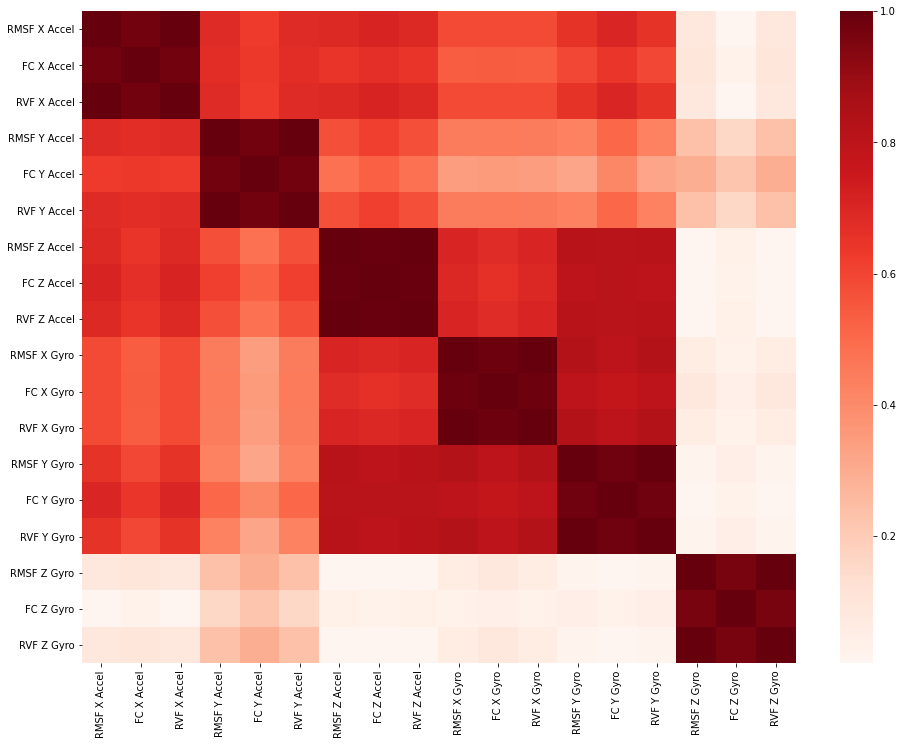

In [18]:
correlation_analysis(datasets_dic[CLASS_FEATS], LABELS)

## Part 3 - Classification Pipeline

### 3.1. Create train/test datasets

In [19]:
## Function to Create TRAIN/VALIDATE/TEST data sets
def create_train_test(dataset, target_label, test_size):  
    '''
    input: get dataset and desired target label to perform classification
    output: train/test splits
    '''
    df = dataset.copy()
    
    target_dic = {}
       
    # store all label columns in a dictionary
    for label in target_label_list:
        target_dic.update({label:df.pop(label)})
        
    # split data
    X_train, X_test, y_train, y_test = train_test_split(df, target_dic[target_label], test_size=test_size, random_state=0)
        
    return X_train, X_test, y_train, y_test

In [20]:
# create train set
X_train, X_test_, y_train, y_test_ = create_train_test(datasets_dic[CLASS_FEATS], LABELS, test_size = 1)

print('X_train shape = {} , y_train shape = {}'.format(X_train.shape, y_train.shape))
print('X_test shape = {} , y_test shape = {}'.format(X_test_.shape, y_test_.shape))

X_train shape = (3589, 18) , y_train shape = (3589,)
X_test shape = (1, 18) , y_test shape = (1,)


In [21]:
# create test set
X_train_, X_test, y_train_, y_test = create_train_test(test_datasets_dic[CLASS_FEATS], LABELS, test_size = len(test_datasets_dic[CLASS_FEATS])-1)

print('X_train shape = {} , y_train shape = {}'.format(X_train_.shape, y_train_.shape))
print('X_test shape = {} , y_test shape = {}'.format(X_test.shape, y_test.shape))

X_train shape = (1, 18) , y_train shape = (1,)
X_test shape = (1606, 18) , y_test shape = (1606,)


### 3.2. Create Classification pipeline

In [23]:
def clf_pipeline(X_train, y_train, HalvGrid = False):
    
    # cross validation nfolds
    cv = 5
    
    # classifier to use for feature selection
    feat_selection_clf = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state = 0)
    
    # create pipeline
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('selector', SFS(estimator = feat_selection_clf, 
                                      k_features=(10,X_train.shape[1]), 
                                      forward=True, 
                                      floating=False, 
                                      scoring='accuracy', 
                                      cv=cv, 
                                      n_jobs=-1)),
                     ('classifier', RandomForestClassifier())])
    
    # set parameter grid
    param_grid = [
        {'selector':[SFS(estimator = feat_selection_clf)],
                        'selector__estimator__n_estimators':[50, 100],
                        'selector__estimator__max_depth':[10,20,30]},

#         {'selector':[RFE(estimator= feat_selection_clf)],
#                         'selector__estimator__n_estimators':[5, 10],
#                         'selector__estimator__max_depth':[3,4], 
#          'selector__n_features_to_select':[1,2]},
        
#         {'selector':[RFECV(estimator = feat_selection_clf, min_features_to_select = 1)],
#                          'selector__estimator__n_estimators':[5, 10],
#                          'selector__estimator__max_depth':[3,4]},
        
        {'classifier':[RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state = 0)],
         'classifier__n_estimators':[50, 100],
         'classifier__max_depth':[30, 50, 70]}]
    
    # dictionary of evaluation scores
    scoring = {
        'precision_score': make_scorer(precision_score, average='macro'),
        'recall_score': make_scorer(recall_score, average='macro'),
        'accuracy_score': make_scorer(accuracy_score),
        'f1_score':make_scorer(f1_score, average='macro')}

    # gridsearch 
    if HalvGrid:
        # HalvingGridSearch
        grid = HalvingGridSearchCV(pipe, 
                                   param_grid, 
                                   cv = cv, 
                                   scoring = scoring,
                                   refit ='accuracy_score',
                                   return_train_score=True,
                                   random_state = 0,
                                   n_jobs = -1,
                                   verbose = 0)
    else:
        grid = GridSearchCV(pipe, 
                            param_grid, 
                            scoring = scoring,
                            n_jobs = -1,
                            refit ='accuracy_score',
                            cv = cv, 
                            verbose = 0,
                            return_train_score=True)
    
    grid.fit(X_train, y_train)
    
    return grid 

In [24]:
# run the classification pipeline
model_ = clf_pipeline(X_train, y_train)

In [25]:
# get parameters of the best model
print("Best estimator via GridSearch \n", model_.best_estimator_)

Best estimator via GridSearch 
 Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selector',
                 SequentialFeatureSelector(clone_estimator=True, cv=5,
                                           estimator=RandomForestClassifier(bootstrap=True,
                                                                            ccp_alpha=0.0,
                                                                            class_weight=None,
                                                                            criterion='gini',
                                                                            max_depth=10,
                                                                            max_features='auto',
                                                                            max_leaf_nodes=None,
                                                                            max_samples

### 3.3. Export Model

In [26]:
# model name/directory
model_name = 'model.joblib'
model_name = os.path.join(path_, model_name)

# dump model
joblib.dump(model_, model_name)

['C:\\Users\\CARIS\\Google Drive\\UBC\\PhD\\Terrain Classification\\PythonScripts\\Results\\20210205-163034\\model.joblib']

## Part 4 - Evaluation

### 4.1. Evaluation score

In [27]:
# accuracy
print('Accuracy score = {:0.2f}'.format(model_.score(X_test, y_test) * 100, '.2f'))

y_pred = model_.predict(X_test)

# f1_score
f_score = f1_score(y_test, y_pred, average = 'macro')* 100
print('F1-score = {:0.2f}'.format(f_score))

# recall
recall_ = recall_score(y_test, y_pred, average = 'macro')* 100
print('Recall score = {:0.2f}'.format(recall_))

Accuracy score = 91.28
F1-score = 91.07
Recall score = 88.99


### 4.2. Confusion matrix

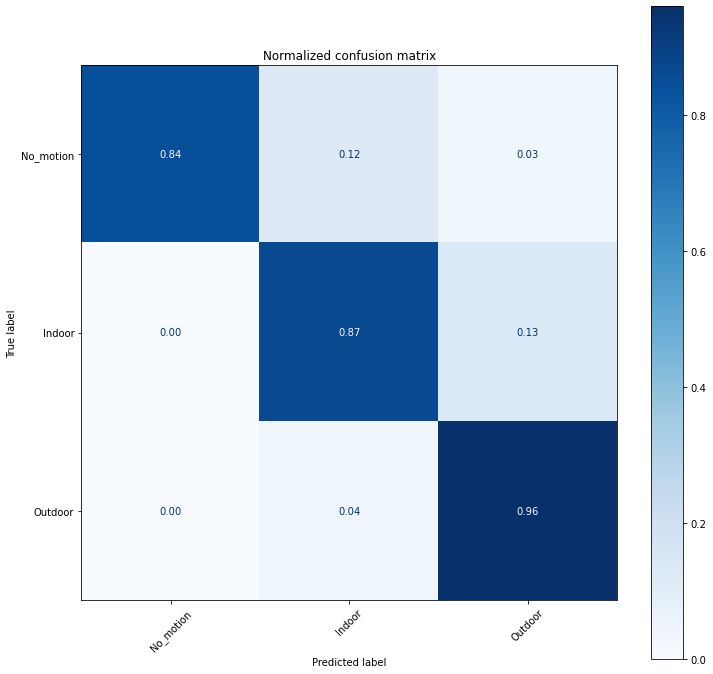

In [28]:
# confusion matrix
title = "Normalized confusion matrix"

disp = plot_confusion_matrix(model_, X_test, y_test, display_labels=target_label_dic[LABELS],
                             cmap=plt.cm.Blues,
                             normalize='true',
                             xticks_rotation = 45,
                             values_format = '.2f')
disp.ax_.set_title(title)
disp.ax_.grid(False)
disp.figure_.set_size_inches(12,12)

# save confusion matrix
fig_name = 'confusion_matrix.jpg'
fig_name = os.path.join(path_, fig_name)
plt.savefig(fig_name)

### 4.3. Analyze computational performance

In [29]:
# computational performance
X_Test_test = X_test[:1].copy()

# method 1
%timeit y_pred = model_.predict(X_Test_test)

# method 2
time1 = time.time()
y_pred = model_.predict(X_Test_test)
time2 = time.time()
print('prediction time: {} ms'.format((time2-time1)*1000))

105 ms ± 803 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
prediction time: 104.93898391723633 ms


## Part 5 - GridSearch Summary

### 5.1. Model best score

In [30]:
# Mean cross-validated score of the best_estimator
print('Best feature combination had a CV accuracy of:', model_.best_score_)

Best feature combination had a CV accuracy of: 0.9308970757916575


### 5.2. Model best parameters

In [31]:
print("Best parameters via GridSearch \n", model_.best_params_)

Best parameters via GridSearch 
 {'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False), 'classifier__max_depth': 30, 'classifier__n_estimators': 100}


### 5.3. Visualize GridSearch results
##### Source: https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search

In [32]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=4,
                          negative=True,
                          graph=True,
                          display_all_params=False):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    
    clf_stdev = grid_clf.cv_results_['std_test_accuracy_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_accuracy_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_accuracy_score']
    else:
        best_mean = best_row['mean_test_accuracy_score']
    best_stdev = best_row['std_test_accuracy_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_accuracy_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_accuracy_score']
    else:
        means = scores_df['mean_test_accuracy_score']
    stds = scores_df['std_test_accuracy_score']
    params = scores_df['param_' + param_name]
    
    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

best parameters: {'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False), 'classifier__max_depth': 30, 'classifier__n_estimators': 100}
best score:      0.93090 (+/-0.01142)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector,param_selector__estimator__max_depth,param_selector__estimator__n_estimators,param_classifier,param_classifier__max_depth,param_classifier__n_estimators,...,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_train_f1_score,split1_train_f1_score,split2_train_f1_score,split3_train_f1_score,split4_train_f1_score,mean_train_f1_score,std_train_f1_score
7,258.179740,4.545274,0.506110,0.274839,NaN,NaN,NaN,"RandomForestClassifier(bootstrap=True, ccp_alp...",30,100,...,0.917638,0.014459,1,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,0.000000
9,255.002961,3.346147,0.568274,0.291310,NaN,NaN,NaN,"RandomForestClassifier(bootstrap=True, ccp_alp...",50,100,...,0.917638,0.014459,1,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,0.000000
11,189.655437,7.653658,0.123732,0.023165,NaN,NaN,NaN,"RandomForestClassifier(bootstrap=True, ccp_alp...",70,100,...,0.917638,0.014459,1,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,0.000000
6,245.297328,6.190742,0.456138,0.597014,NaN,NaN,NaN,"RandomForestClassifier(bootstrap=True, ccp_alp...",30,50,...,0.917207,0.013627,4,0.999739,0.99974,0.999739,0.999739,1.0,0.999792,0.000104


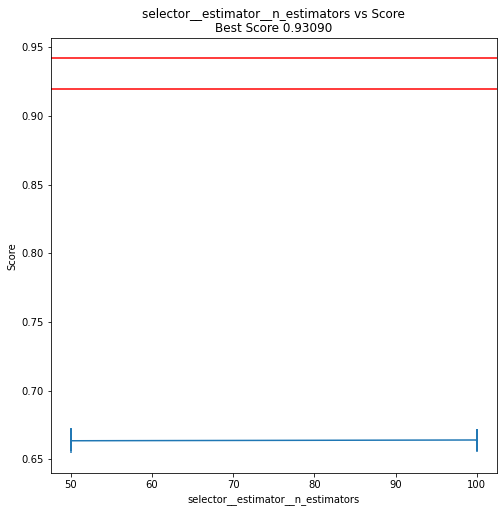

In [33]:
GridSearch_table_plot(model_, "selector__estimator__n_estimators", negative=False)

### 5.4. Gridsearch evaluation - multiple scores
##### source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

In [34]:
def score_evaluation(grid, param):

    # plotting the results
    results = grid.cv_results_
    
    scoring = {
            'precision_score': make_scorer(precision_score, average='macro'),
            'recall_score': make_scorer(recall_score, average='macro'),
            'accuracy_score': make_scorer(accuracy_score),
            'f1_score':make_scorer(f1_score, average='macro')}

    plt.figure(figsize=(10, 8))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=16)

    plt.xlabel(param)
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(0, 100)
    ax.set_ylim(0.0, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_selector__estimator__n_estimators'].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k','r','b']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

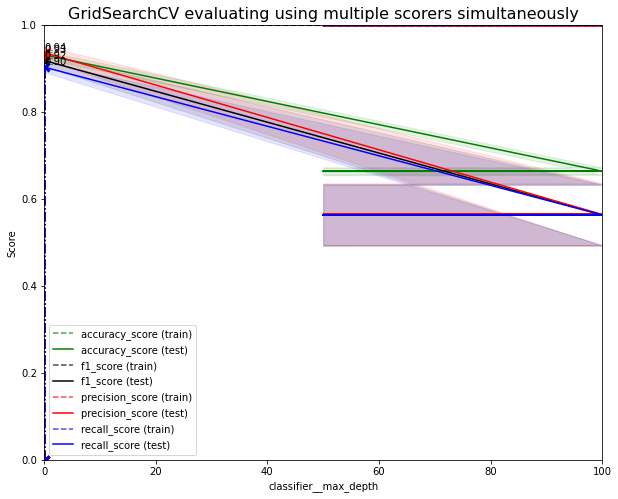

In [35]:
score_evaluation(model_, "classifier__max_depth")

### 5.5. Gridsearch report

In [36]:
results = model_.cv_results_
# results

## Part 6 - Feature selection summary

### 6.1. Feature selection score & best features

In [37]:
# get prediction score of best selected features
print('\nFeature selection score: {}'.format(model_.best_estimator_['selector'].k_score_))


Feature selection score: 0.9325718814466033


In [38]:
# get best features
best_feats_idx = model_.best_estimator_['selector'].k_feature_idx_;

best_feats = list(X_test.columns[list(best_feats_idx)].values.tolist()) 

print('\nBest features: \n{}'.format(best_feats))

# save a list of selected features
filename = 'selected_features.csv'
filename = os.path.join(path_, filename)

with open(filename, "w") as f:
    writer = csv.writer(f)
    writer.writerows([c.strip() for c in r.strip(', ').split(',')] for r in best_feats)


Best features: 
['RMSF X Accel', 'FC X Accel', 'RVF X Accel', 'RMSF Y Accel', 'RMSF Z Accel', 'FC Z Accel', 'RVF Z Accel', 'RMSF X Gyro', 'FC X Gyro', 'RVF X Gyro', 'RMSF Y Gyro', 'FC Y Gyro', 'RVF Y Gyro', 'RMSF Z Gyro', 'RVF Z Gyro']


In [39]:
# test shape of the feature transformed dataframe
X_test_transformed = model_.best_estimator_['selector'].transform(X_test)
print('shape of the transformed dataset with best features: {}'.format(X_test_transformed.shape))

shape of the transformed dataset with best features: (1606, 15)


### 6.2. Visualize feature selection scores

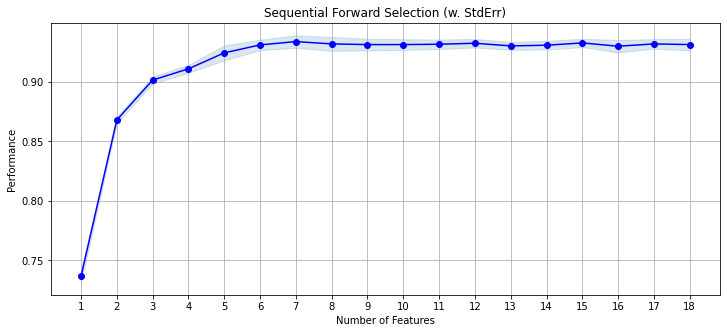

In [40]:
# plotting feature selection characteristics
plot_sfs(model_.best_estimator_['selector'].get_metric_dict(), kind='std_err', figsize=(12,5))
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid(b=True, which='major', axis='both')

# save confusion matrix
fig_name = 'feature_selection.jpg'
fig_name = os.path.join(path_, fig_name)
plt.savefig(fig_name)